Link to dataset: https://www.kaggle.com/datasets/arnavsmayan/fitness-tracker-dataset?resource=download

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
file_path = '/content/drive/MyDrive/Colab Notebooks/active_track_final.csv'
# file_path = '/content/drive/MyDrive/Colab Notebooks/fitness_tracker_dataset.csv'

data = pd.read_csv(file_path)


In [88]:
data.head()

,time,heart_rate,spo2,temperature
0,2024-09-01 00:00:00,98,93.673235,35.974957
1,2024-09-01 00:01:00,88,91.378219,35.809455
2,2024-09-01 00:02:00,74,97.446620,35.488393
3,2024-09-01 00:03:00,67,99.143351,36.742165
4,2024-09-01 00:04:00,80,91.980038,36.453148


In [89]:
data.shape

(50000, 4)

In [20]:
# @title old
# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))

# scaled_data = scaler.fit_transform(data)

In [90]:
data.head()

,time,heart_rate,spo2,temperature
0,2024-09-01 00:00:00,98,93.673235,35.974957
1,2024-09-01 00:01:00,88,91.378219,35.809455
2,2024-09-01 00:02:00,74,97.446620,35.488393
3,2024-09-01 00:03:00,67,99.143351,36.742165
4,2024-09-01 00:04:00,80,91.980038,36.453148


In [91]:
original_data = data.copy()

In [92]:
# Convert 'time' column to datetime if it's not already
data['time'] = pd.to_datetime(data['time'])
data.head()

,time,heart_rate,spo2,temperature
0,2024-09-01 00:00:00,98,93.673235,35.974957
1,2024-09-01 00:01:00,88,91.378219,35.809455
2,2024-09-01 00:02:00,74,97.446620,35.488393
3,2024-09-01 00:03:00,67,99.143351,36.742165
4,2024-09-01 00:04:00,80,91.980038,36.453148


In [93]:


# Extract hour, minute, and day of the week from the 'time' column
data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute
data['day_of_week'] = data['time'].dt.dayofweek

# Drop the original 'time' column if not needed
data = data.drop('time', axis=1)




In [94]:
data.head()

,heart_rate,spo2,temperature,hour,minute,day_of_week
0,98,93.673235,35.974957,0,0,6
1,88,91.378219,35.809455,0,1,6
2,74,97.446620,35.488393,0,2,6
3,67,99.143351,36.742165,0,3,6
4,80,91.980038,36.453148,0,4,6


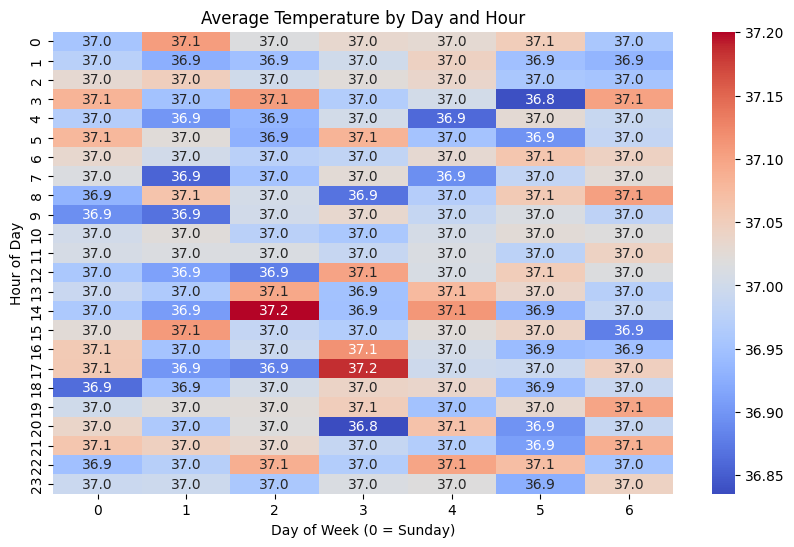

In [95]:
# @title Average Temperature by Day and Hour

import matplotlib.pyplot as plt
import seaborn as sns

temp_pivot = data.pivot_table(index='hour', columns='day_of_week', values='temperature', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(temp_pivot, cmap='coolwarm', annot=True, fmt='.1f')
plt.xlabel('Day of Week (0 = Sunday)')
plt.ylabel('Hour of Day')
_ = plt.title('Average Temperature by Day and Hour')

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
# Define the features and target
# features = [ 'time','heart_rate', 'spo2', 'temperature']


# Define the features including the new time-based features
features = ['hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature']

In [98]:

# Create sequences for training the LSTM model
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Create sequences
seq_length = 7
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [101]:
# Define the model (LSTM layers, etc.)
model = Sequential()

# Increase units in LSTM layers
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

# Adjust the Dense layer as well
model.add(Dense(100))
model.add(Dense(len(features)))

In [ ]:
# @title old

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=50))
model.add(Dense(units=y.shape[1]))




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [103]:
# Define the model architecture (assuming you have already done this)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [104]:
# Fit the model with the validation data, early stopping, and learning rate adjustment
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.1709 - mae: 0.1709 - val_loss: 0.1400 - val_mae: 0.1400 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.1438 - mae: 0.1438 - val_loss: 0.1385 - val_mae: 0.1385 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.1432 - mae: 0.1432 - val_loss: 0.1407 - val_mae: 0.1407 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.1422 - mae: 0.1422 - val_loss: 0.1387 - val_mae: 0.1387 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.1422 - mae: 0.1422 - val_loss: 0.1372 - val_mae: 0.1372 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.1419 - mae: 0.1419 - val_loss: 0.1374 - val_mae: 0.1374 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.1415 - mae: 0.1415 - val_loss: 0.1356 - val_mae: 0.

In [ ]:
# @title old
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - loss: 0.0886 - val_loss: 0.0841
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0847 - val_loss: 0.0840
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 0.0844 - val_loss: 0.0842
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0843 - val_loss: 0.0840
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.0844 - val_loss: 0.0847
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 0.0845 - val_loss: 0.0843
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0843 - val_loss: 0.0840
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0845 - val_loss: 0.0840
Epoch 9/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step - loss: 0.0844 - val_loss: 0.0839
Epoch 10/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - loss: 0.0845 - val_loss: 0.0841
Epoch 11/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - loss: 0.0845 - val_loss: 0.0841
Epoch 12

In [105]:
# Make predictions on the validation set
predicted = model.predict(X_val)

# Inverse scale the predictions and actual values to their original scale
predicted = scaler.inverse_transform(predicted)
y_true = scaler.inverse_transform(y_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mean Squared Error
mse = mean_squared_error(y_true, predicted)
print(f'Mean Squared Error: {mse}')

# Mean Absolute Error
mae = mean_absolute_error(y_true, predicted)
print(f'Mean Absolute Error: {mae}')

# R² Score
r2 = r2_score(y_true, predicted)
print(f'R² Score: {r2}')


Mean Squared Error: 35.24180727644004
Mean Absolute Error: 2.697668233384333
R² Score: 0.4668851389622816


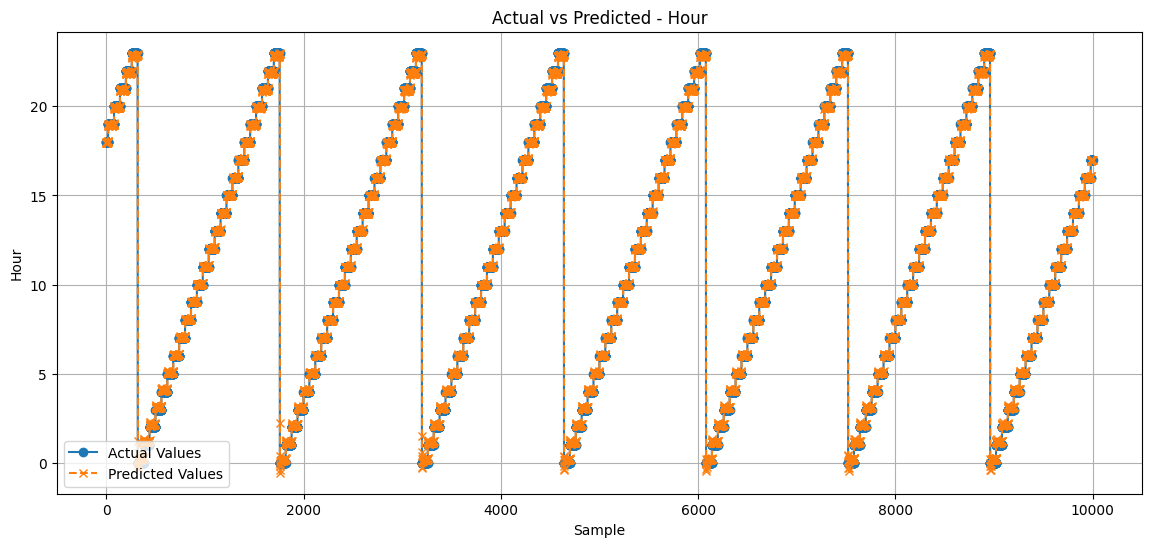

In [108]:
# Plot the actual vs predicted values for one of the features
plt.figure(figsize=(14, 6))

# You can loop through features or choose one specific feature
feature_index = 0  # Index of the feature you want to plot
plt.plot(y_true[:, feature_index], label='Actual Values', marker='o')
plt.plot(predicted[:, feature_index], label='Predicted Values', marker='x', linestyle='--')
plt.title(f'Actual vs Predicted - {features[feature_index].replace("_", " ").title()}')
plt.xlabel('Sample')
plt.ylabel(features[feature_index].replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.show()


In [109]:
features = ['hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature']

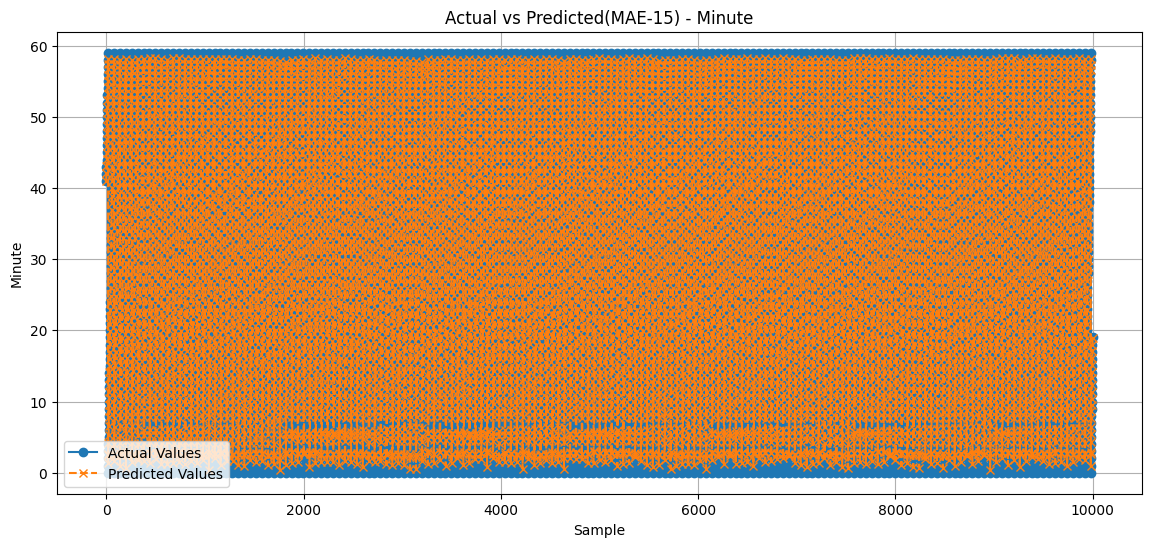

In [110]:
# Plot the actual vs predicted values for one of the features
plt.figure(figsize=(14, 6))

# You can loop through features or choose one specific feature
feature_index = 1  # Index of the feature you want to plot
plt.plot(y_true[:, feature_index], label='Actual Values', marker='o')
plt.plot(predicted[:, feature_index], label='Predicted Values', marker='x', linestyle='--')
plt.title(f'Actual vs Predicted - {features[feature_index].replace("_", " ").title()}')
plt.xlabel('Sample')
plt.ylabel(features[feature_index].replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.show()

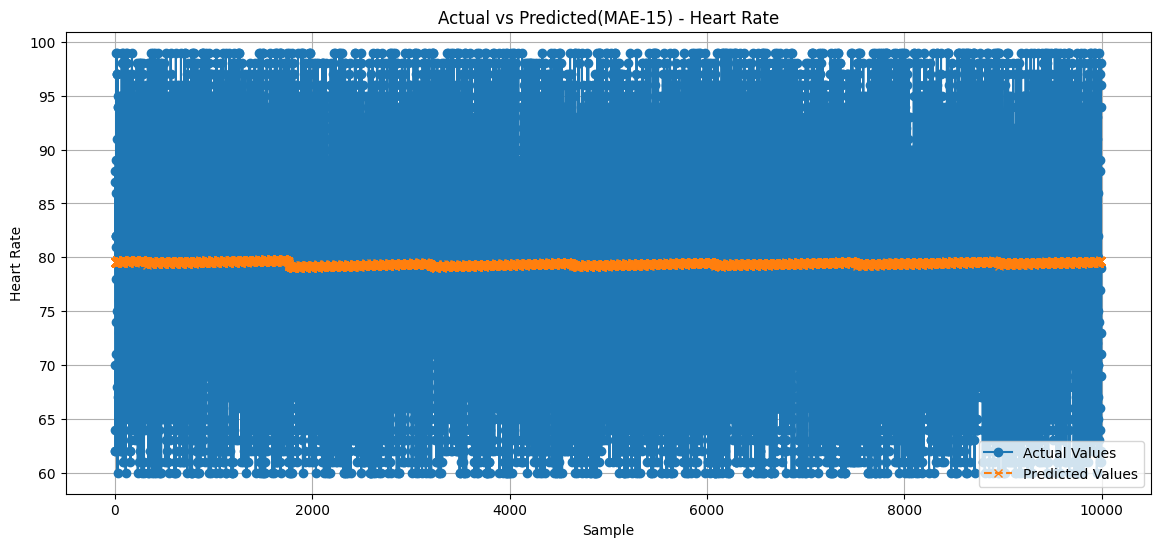

In [111]:
# Plot the actual vs predicted values for one of the features (e.g., steps)
plt.figure(figsize=(14, 6))

# You can loop through features or choose one specific feature
feature_index = 3  # Index of the feature you want to plot ('hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature'.)
plt.plot(y_true[:, feature_index], label='Actual Values', marker='o')
plt.plot(predicted[:, feature_index], label='Predicted Values', marker='x', linestyle='--')
plt.title(f'Actual vs Predicted(MAE-15) - {features[feature_index].replace("_", " ").title()}')
plt.xlabel('Sample')
plt.ylabel(features[feature_index].replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.show()

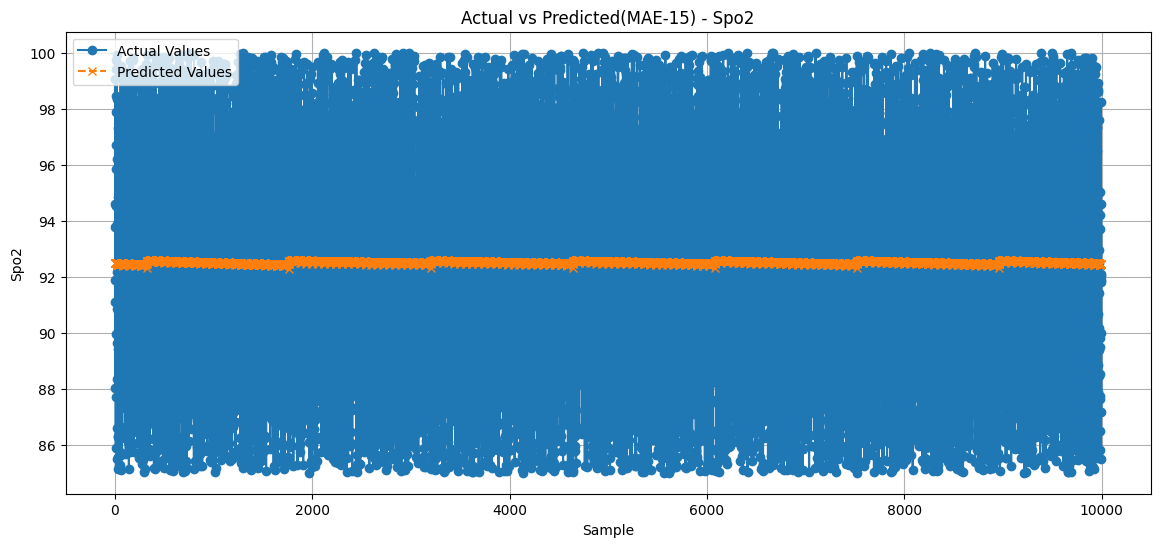

In [112]:
# Plot the actual vs predicted values for one of the features (e.g., steps)
plt.figure(figsize=(14, 6))

# You can loop through features or choose one specific feature
feature_index = 4  # Index of the feature you want to plot ('hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature'.)
plt.plot(y_true[:, feature_index], label='Actual Values', marker='o')
plt.plot(predicted[:, feature_index], label='Predicted Values', marker='x', linestyle='--')
plt.title(f'Actual vs Predicted(MAE-15) - {features[feature_index].replace("_", " ").title()}')
plt.xlabel('Sample')
plt.ylabel(features[feature_index].replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.show()

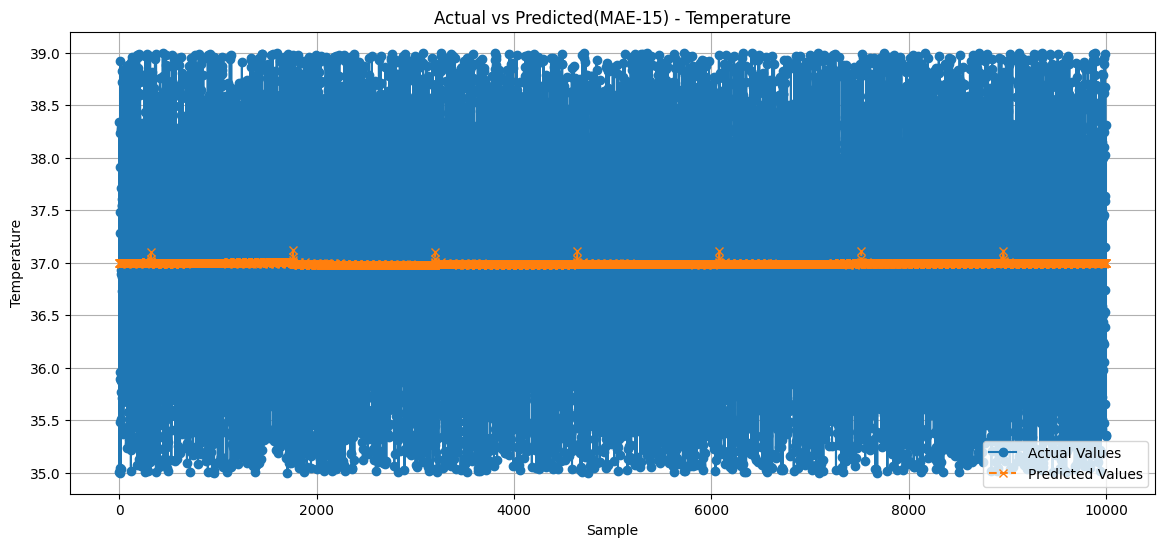

In [113]:
# Plot the actual vs predicted values for one of the features (e.g., steps)
plt.figure(figsize=(14, 6))

# You can loop through features or choose one specific feature
feature_index = 5  # Index of the feature you want to plot ('hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature'.)
plt.plot(y_true[:, feature_index], label='Actual Values', marker='o')
plt.plot(predicted[:, feature_index], label='Predicted Values', marker='x', linestyle='--')
plt.title(f'Actual vs Predicted(MAE-15) - {features[feature_index].replace("_", " ").title()}')
plt.xlabel('Sample')
plt.ylabel(features[feature_index].replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.show()

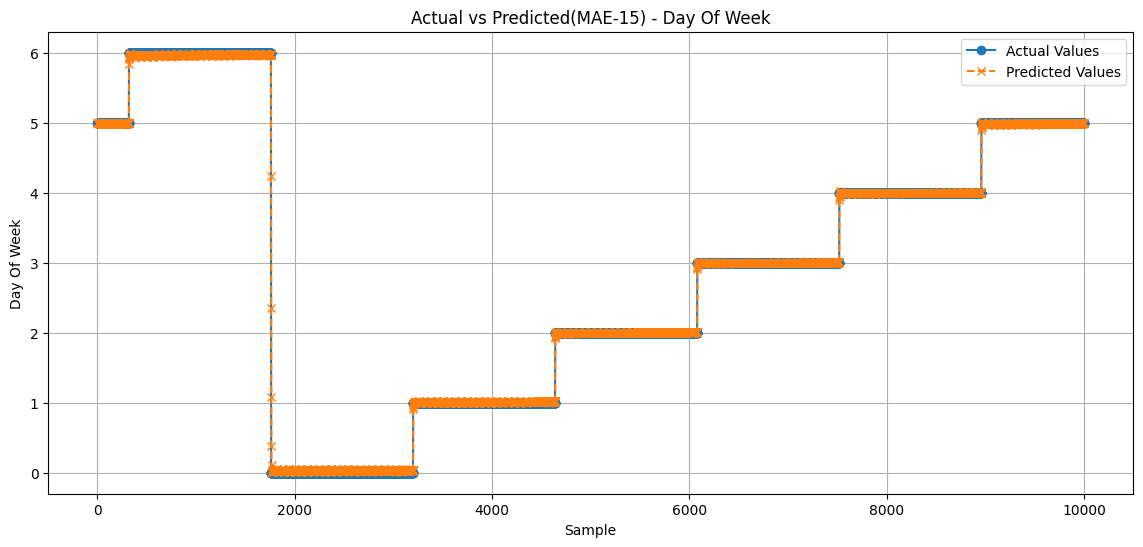

In [114]:
# Plot the actual vs predicted values for one of the features (e.g., steps)
plt.figure(figsize=(14, 6))

# You can loop through features or choose one specific feature
feature_index = 2  # Index of the feature you want to plot ('hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature'.)
plt.plot(y_true[:, feature_index], label='Actual Values', marker='o')
plt.plot(predicted[:, feature_index], label='Predicted Values', marker='x', linestyle='--')
plt.title(f'Actual vs Predicted(MAE-15) - {features[feature_index].replace("_", " ").title()}')
plt.xlabel('Sample')
plt.ylabel(features[feature_index].replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.show()

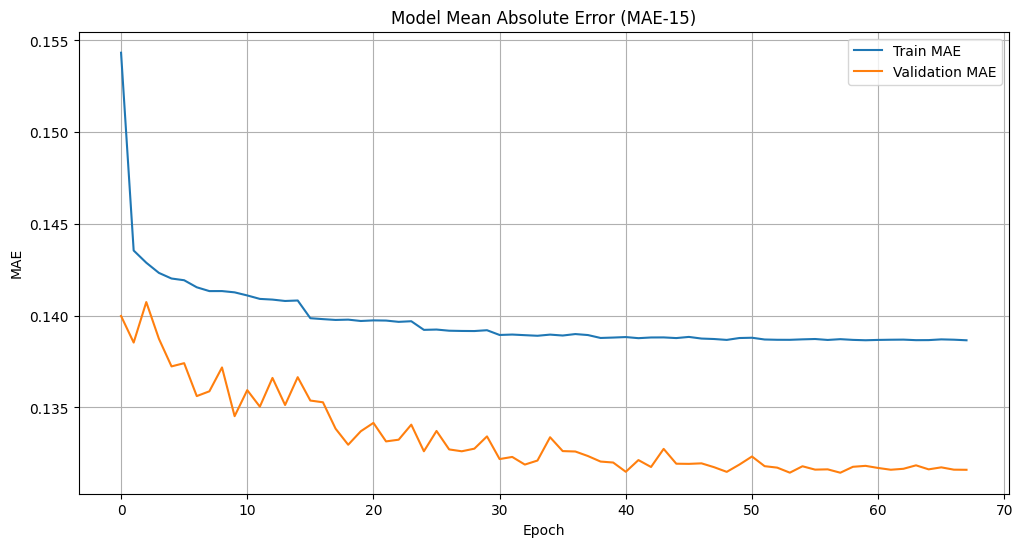

In [115]:
# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE-15)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

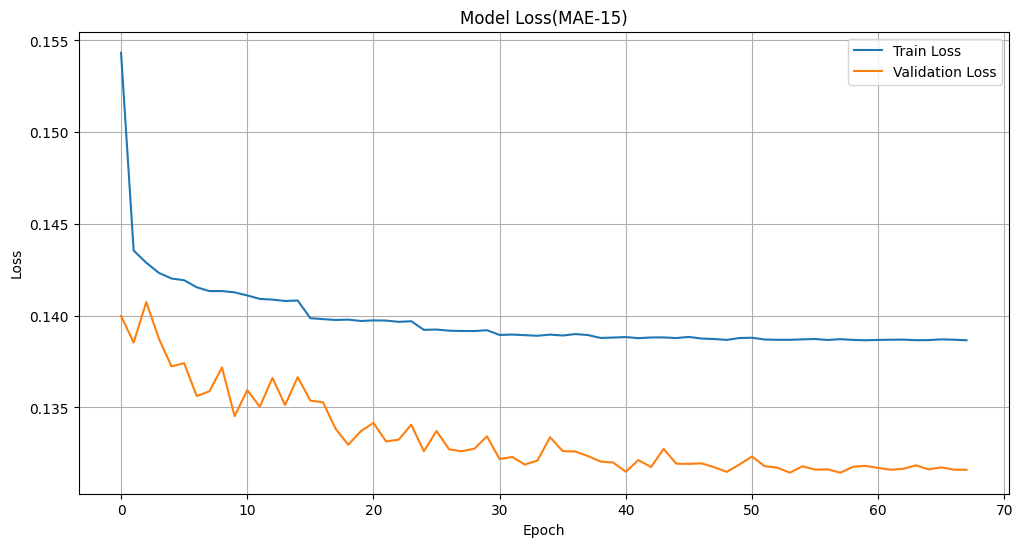

In [116]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss(MAE-15)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# @title dddd

def predict_new_data(model, new_data, scaler, seq_length=7):
    """
    Predicts future values using the trained model and new data.

    Args:
        model: The trained Keras model.
        new_data: A pandas DataFrame containing the new data.
        scaler: The scaler object used to preprocess the original data.
        seq_length: The length of the input sequence for the model.

    Returns:
        A NumPy array containing the predicted values.
    """

    # Scale the new data using the same scaler
    scaled_new_data = scaler.transform(new_data)
    
    # scaled_data = scaler.fit_transform(data)

    # Create sequences
    x_new = []
    for i in range(len(scaled_new_data) - seq_length):
        x_new.append(scaled_new_data[i:i + seq_length])

    # x_new = np.array(x_new)
    # Use the last 'seq_length' rows to create the sequence
    x_new = np.array([scaled_new_data[-seq_length:]])

    x_new = np.reshape(x_new, (x_new.shape[0], x_new.shape[1], x_new.shape[2]))

    # Check if x_new has enough dimensions and reshape if necessary
    # if len(x_new.shape) == 2:
    #     x_new = np.reshape(x_new, (x_new.shape[0], x_new.shape[1], 1))  # Reshape to 3D if it's 2D
    # elif len(x_new.shape) == 3:
    #     pass  # Already in the correct shape
    # else:
    #     raise ValueError("Input data has unexpected number of dimensions.")

    # Predict using the model
    predicted = model.predict(x_new)

    # Inverse scale the predictions
    predicted = scaler.inverse_transform(predicted)

    return predicted


In [117]:
model.save('/content/drive/MyDrive/Colab Notebooks/active_track_mae2_final_model.h5')

In [12]:
# loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/fitness_model_final_15_mae.h5')
from keras.metrics import MeanAbsoluteError



In [13]:

custom_objects = {'mae': MeanAbsoluteError()}


loaded_model = load_model('C:\\Users\\AWURABENA\\Desktop\\SoloProject\\active_track\\server\\model\\active_track_mae2_final_model.h5', custom_objects=custom_objects)

In [22]:
def predict_future_days(model, initial_data, scaler, seq_length=7, num_days=1):
    """
    Predicts future values using the trained model and initial data.

    Args:
        model: The trained Keras model.
        initial_data: A pandas DataFrame containing the initial data (at least seq_length rows).
        scaler: The scaler object used to preprocess the original data.
        seq_length: The length of the input sequence for the model.
        num_days: The number of future days to predict.

    Returns:
        A pandas DataFrame containing the predicted values for the specified number of days.
    """

    # Ensure initial_data has at least seq_length rows
    if len(initial_data) < seq_length:
        raise ValueError(f"initial_data must have at least {seq_length} rows.")

    # Scale the initial data using the scaler
    scaled_initial_data = scaler.fit_transform(initial_data)
    

    # Convert scaled data to a list for easier manipulation
    scaled_data_list = list(scaled_initial_data)

    predictions = []

    for _ in range(num_days):
        # Get the last 'seq_length' scaled data points
        input_seq = np.array(scaled_data_list[-seq_length:]).reshape(1, seq_length, -1)

        # Predict the next day (returns a scaled prediction)
        predicted_scaled = model.predict(input_seq)

        # Append the scaled prediction to the data list for the next prediction
        scaled_data_list.append(predicted_scaled[0])

        # Inverse transform the prediction to get original scale
        predicted = scaler.inverse_transform(predicted_scaled)[0]

        # Handle time feature roll-over logic
        # For simplicity, assume minute rolls over after 59, hour after 23, day_of_week after 6 (Sunday to Monday)
        last_time_features = initial_data.iloc[-1][['hour', 'minute', 'day_of_week']].copy()

        # Update minute
        last_time_features['minute'] += 1
        if last_time_features['minute'] >= 60:
            last_time_features['minute'] = 0
            last_time_features['hour'] += 1

        # Update hour
        if last_time_features['hour'] >= 24:
            last_time_features['hour'] = 0
            last_time_features['day_of_week'] += 1

        # Update day_of_week
        if last_time_features['day_of_week'] >= 7:
            last_time_features['day_of_week'] = 0

        # Replace the predicted time features with the updated ones
        predicted[:3] = last_time_features

        # Append the prediction to the predictions list
        predictions.append(predicted)

    # Define column names based on your original data
    columns = ['hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature']

    # Convert the predictions list to a DataFrame
    predictions_df = pd.DataFrame(predictions, columns=columns)

    return predictions_df


In [42]:
data.head()

,heart_rate,spo2,temperature,hour,minute,day_of_week
0,152,87.227761,36.705340,0,0,6
1,142,91.209515,38.997412,0,1,6
2,64,92.250881,36.743313,0,2,6
3,156,88.952607,35.597518,0,3,6
4,121,90.347150,36.607478,0,4,6


In [23]:
# Define the column names
columns = ['hour', 'minute', 'day_of_week', 'heart_rate', 'spo2', 'temperature']

# Generate random test data for 7 days
np.random.seed(42)  # For reproducibility
test_data_7_days = pd.DataFrame({
    'hour': np.random.randint(0, 24, size=7),
    'minute': np.random.randint(0, 60, size=7),
    'day_of_week': np.random.randint(0, 7, size=7),
    'heart_rate': np.random.randint(60, 90, size=7),
    'spo2': np.random.uniform(90, 100, size=7),
    'temperature': np.random.uniform(36.0, 37.5, size=7)
}, columns=columns)

# Display the test data
print("7-Day Test Data:")
test_data_7_days

7-Day Test Data:


,hour,minute,day_of_week,heart_rate,spo2,temperature
0,6,57,3,65,95.247564,36.684105
1,19,18,2,61,94.319450,37.177764
2,14,22,5,87,92.912291,36.299511
3,10,10,4,80,96.118529,36.771352
4,7,10,1,60,91.394939,36.888622
5,20,23,3,71,92.921446,36.069676
6,6,52,5,85,93.663618,36.911317


In [24]:
tdays = len(test_data_7_days)

In [25]:
print("7-Day Test Data:")
# print(test_data_7_days)

# Number of future days to predict
num_future_days = 2

# Predict the next 2 days
predicted_future = predict_future_days(loaded_model, test_data_7_days, scaler, seq_length=len(test_data_7_days), num_days=num_future_days)

print("\nPredicted Future Days:")
predicted_future

7-Day Test Data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Predicted Future Days:


,hour,minute,day_of_week,heart_rate,spo2,temperature
0,6.0,53.0,5.0,73.413696,93.758331,36.622303
1,6.0,53.0,5.0,73.439735,93.759567,36.621685


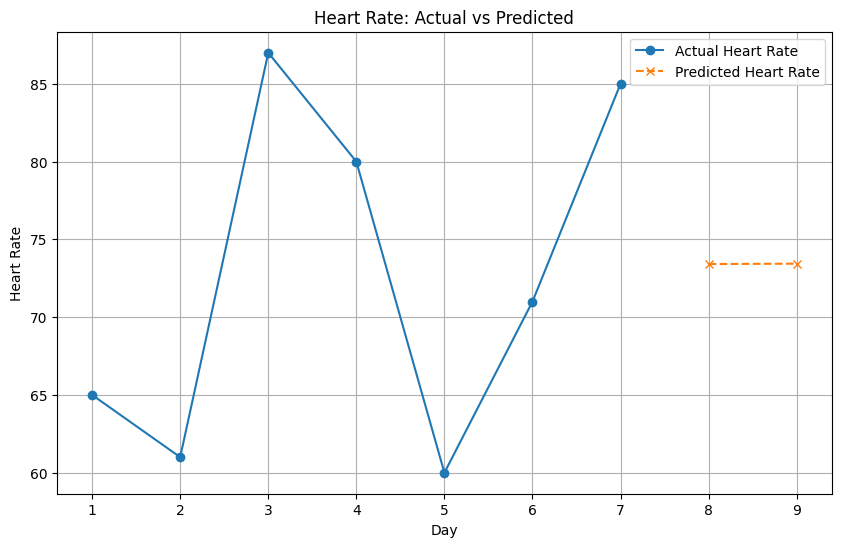

In [26]:
# Combine initial data and predictions for plotting (for heart_rate)
combined_heart_rate = pd.concat([test_data_7_days['heart_rate'], predicted_future['heart_rate']], ignore_index=True)
days = list(range(1, len(combined_heart_rate) + 1))

plt.figure(figsize=(10, 6))
plt.plot(days[:tdays], test_data_7_days['heart_rate'], label='Actual Heart Rate', marker='o')
plt.plot(days[tdays:], predicted_future['heart_rate'], label='Predicted Heart Rate', marker='x', linestyle='--')
plt.title('Heart Rate: Actual vs Predicted')
plt.xlabel('Day')
plt.ylabel('Heart Rate')
plt.legend()
plt.grid(True)
plt.show()


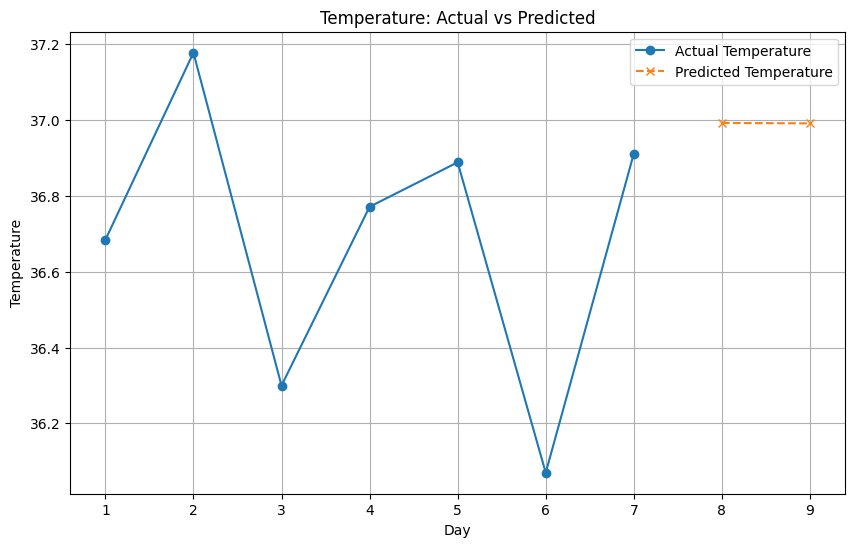

In [134]:
# Combine initial data and predictions for plotting (for temperature)
combined_temperature = pd.concat([test_data_7_days['temperature'], predicted_future['temperature']], ignore_index=True)
days = list(range(1, len(combined_temperature) + 1))

plt.figure(figsize=(10, 6))
plt.plot(days[:tdays], test_data_7_days['temperature'], label='Actual Temperature', marker='o')
plt.plot(days[tdays:], predicted_future['temperature'], label='Predicted Temperature', marker='x', linestyle='--')
plt.title('Temperature: Actual vs Predicted')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Example: Adding dates to the predictions
initial_dates = pd.date_range(start='2024-01-01', periods=7, freq='D')
prediction_dates = pd.date_range(start=initial_dates[-1] + pd.Timedelta(days=1), periods=num_future_days, freq='D')
predicted_future['date'] = prediction_dates


In [ ]:
predicted_future.to_csv('predicted_future_days.csv', index=False)
predicted_future.head()

,heart_rate,temperature,date
0,119.719818,37.278454,2024-01-08
1,119.666298,37.276745,2024-01-09
2,119.601097,37.274414,2024-01-10


In [ ]:
# Define column names based on the original data structure
columns = [ 'heart_rate', 'temperature']

# Convert the prediction array to a DataFrame
predicted_df = pd.DataFrame(predicted_future, columns=columns)

# Display the DataFrame
predicted_df


,heart_rate,temperature
0,119.719818,37.278454
1,119.666298,37.276745
2,119.601097,37.274414


Geneterating randome data

In [86]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Number of data points
num_data_points = 50000

# Generate synthetic data

# Simulating realistic ranges for heart rate, SpO2, and temperature
heart_rate = np.random.randint(60, 100, size=num_data_points)  # Heart rate range for varied scenarios
spo2 = np.random.uniform(85, 100, size=num_data_points)        # SpO2 with a range that includes normal and critical values
temperature = np.random.uniform(35.0, 39.0, size=num_data_points)  # Body temperature with more variability

# Adding time data with a minute interval
time = pd.date_range(start='2024-09-01 00:00:00', periods=num_data_points, freq='T')

# Create a DataFrame
df = pd.DataFrame({
    'time': time,
    'heart_rate': heart_rate,
    'spo2': spo2,
    'temperature': temperature,
})

# Save to CSV
csv_path = '/content/drive/MyDrive/Colab Notebooks/active_track_final.csv'
df.to_csv(csv_path, index=False)

# Output the path to the CSV
csv_path



'/content/drive/MyDrive/Colab Notebooks/active_track_final.csv'